In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.odr as odr

# Simple Orthogonal Distance Regression Examples

**This is a simplified notebook to give examples on how to run ODR. For a more thorough explanation, see the ODR_exploration notebook.**

This notebook will show you how to run ODR for a few situations and how to interpret the results. Make sure you are following the right case for your situation.

1. Data has uncertainty in x- and y- dimensions
2. Data only has uncertainty in y- dimension (zero uncertainty in x)

Each of the cases will use the "preliminaries." So make sure you read that before jumping to your situation.

## 0. Preliminaries

First we define a function which will be used as our model. In this notebook we use a Gaussian with free parameters of amplitude, width, and horizontal offset.

In [2]:
def gauss(B, x):
    '''
    Gaussian function y = A * exp(-(x-x0)^2/(2σ^2))
    B is vector of the parameters
        B[0] is the amplitude (A)
        B[1] is the width (σ)
        B[2] is the horizontal offset (x0)
    x is an array of the x values
    
    Returns an array of y values
    '''
    return B[0] * np.exp(-(x - B[2])**2 / (2 * B[1]**2))

Next we create a mock data set. You would **not** do this part for your real data - this is just so we have something to demonstrate with.

In [3]:
A = 3.2
σ = 1.5
x0 = 2.4

xdata = np.arange(-7, 7, .2)
ydata = gauss([A, σ, x0], xdata)

xerr = 0.05 * np.ones_like(xdata)
yerr = 0.3 * np.ones_like(ydata)
xdata_noisy = xdata + xerr * np.random.randn(len(xdata))
ydata_noisy = ydata + yerr * np.random.randn(len(ydata))

<IPython.core.display.Javascript object>


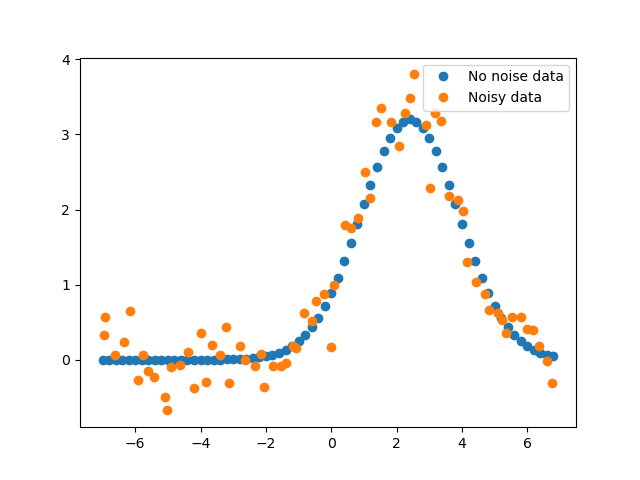

In [4]:
plt.figure()
plt.plot(xdata, ydata, 'o', label='No noise data')
plt.plot(xdata_noisy, ydata_noisy, 'o', label='Noisy data')
plt.legend()

## 1. Data has uncertainty in x- and y- dimensions

Next we stuff our data into the ODR framework and run our fit!
Make sure you specify `sx` and `sy` with your uncertainties when calling `RealData()`.
Note that `beta0` below is your initial guess for your parameters. Here I just picked `[1, 1, 0]` because it's reasonable.

In [5]:
model1 = odr.Model(gauss)
mydata1 = odr.RealData(xdata_noisy, ydata_noisy, sx=xerr, sy=yerr)
myodr1 = odr.ODR(mydata1, model1, beta0=[1, 1, 0])
myoutput1 = myodr1.run()

myoutput1.pprint()

Beta: [ 3.43204784 -1.47054597  2.33348523]
Beta Std Error: [0.10479267 0.05197379 0.05273633]
Beta Covariance: [[ 1.05595885e-02  2.97583619e-03 -3.40091271e-05]
 [ 2.97583619e-03  2.59749062e-03 -5.76082440e-06]
 [-3.40091271e-05 -5.76082440e-06  2.67426872e-03]]
Residual Variance: 1.0399555924811694
Inverse Condition #: 0.10093943346493288
Reason(s) for Halting:
  Sum of squares convergence


The function `pprint()` prints out all the results, but we need to intepret them.  
- `Beta` is an array of the fit's best estimate for your parameters. Here, the algorithm found an amplitude of 3.22, width of -1.56 (interesting that it's negative!), and an offset of 2.37. Not bad!  
- `Beta Covariance` will give you the uncertainties on the results. The uncertainties on the parameters are the square roots of the diagonal of the matrix. More on how to use that below. Note that `Beta Std Error` is **not** the right thing to use! See the ODR_exploration notebook for details.

We can pull out our found values as in the example below.

In [6]:
A1 = myoutput1.beta[0]
σ1 = myoutput1.beta[1]
x01 = myoutput1.beta[2]

A1_unc = np.sqrt(myoutput1.cov_beta[0, 0])
σ1_unc = np.sqrt(myoutput1.cov_beta[1, 1])
x01_unc = np.sqrt(myoutput1.cov_beta[2, 2])

print(f'Our fit values are:\n A1 = {round(A1, 2)} +/- {round(A1_unc, 2)}\n'
 + f' σ1 = {round(σ1, 2)} +/- {round(σ1_unc, 2)}\n'
 + f' x01 = {round(x01, 2)} +/- {round(x01_unc, 2)}')

Our fit values are:
 A1 = 3.43 +/- 0.1
 σ1 = -1.47 +/- 0.05
 x01 = 2.33 +/- 0.05


## 2. Data only has uncertainty in y- dimension

Next we stuff our data into the ODR framework and run our fit!
Make sure you specify `sy` when calling `RealData()` **and use the `ifixx` keyword** when calling `ODR()`.
Note that `beta0` below is your initial guess for your parameters. Here I just picked `[1, 1, 0]` because it's reasonable.

In [7]:
model2 = odr.Model(gauss)
mydata2 = odr.RealData(xdata, ydata_noisy, sy=yerr)
myodr2 = odr.ODR(mydata2, model2, beta0=[1, 1, 0], ifixx=np.zeros(len(xdata)))
myoutput2 = myodr2.run()

myoutput2.pprint()

Beta: [ 3.42925672 -1.45725437  2.33711678]
Beta Std Error: [0.10601375 0.05203833 0.05201517]
Beta Covariance: [[ 1.04561213e-02  2.96405473e-03 -8.40024255e-07]
 [ 2.96405473e-03  2.51937529e-03 -7.90200505e-07]
 [-8.40024255e-07 -7.90200505e-07  2.51713355e-03]]
Residual Variance: 1.0748647404237124
Inverse Condition #: 0.10204023137588095
Reason(s) for Halting:
  Sum of squares convergence


The function `pprint()` prints out all the results, but we need to intepret them.  
- `Beta` is an array of the fit's best estimate for your parameters. Here, the algorithm found an amplitude of 3.21, width of -1.56 (interesting that it's negative!), and an offset of 2.37. Not bad!  
- `Beta Covariance` will give you the uncertainties on the results. The uncertainties on the parameters are the square roots of the diagonal of the matrix. More on how to use that below. Note that `Beta Std Error` is **not** the right thing to use! See the ODR_exploration notebook for details.

We can pull out our found values as in the example below.

In [8]:
A2 = myoutput2.beta[0]
σ2 = myoutput2.beta[1]
x02 = myoutput2.beta[2]

A2_unc = np.sqrt(myoutput2.cov_beta[0, 0])
σ2_unc = np.sqrt(myoutput2.cov_beta[1, 1])
x02_unc = np.sqrt(myoutput2.cov_beta[2, 2])

print(f'Our fit values are:\n A2 = {round(A2, 2)} +/- {round(A2_unc, 2)}\n'
 + f' σ2 = {round(σ2, 2)} +/- {round(σ2_unc, 2)}\n'
 + f' x02 = {round(x02, 2)} +/- {round(x02_unc, 2)}')

Our fit values are:
 A2 = 3.43 +/- 0.1
 σ2 = -1.46 +/- 0.05
 x02 = 2.34 +/- 0.05
